# HW3 Kamenev Vladimir

### Импортим библиотеки (добавил в симуляцию аргумент verbose для возможности отключения принтов)

In [1]:
import numpy as np
import pandas as pd
import time
from functools import partial

from scipy.stats import randint, uniform
from sim_lib import simulation

pd.options.mode.chained_assignment = None


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def eps_greedy(history: pd.DataFrame, eps: float):
    if uniform.rvs() < eps:
        n = history.shape[0]
        return history.index[randint.rvs(0, n)]

    ctr = history['clicks'] / (history['impressions'] + 10)
    n = np.argmax(ctr)
    return history.index[n]

policy = partial(eps_greedy, eps=0.06)

In [3]:
# seed for homework
seed = 18475
np.random.seed(seed=seed)
n = 200000
start = time.time()
output = simulation(policy, n=n, seed=seed,verbose=True)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


136.7223081588745

In [4]:
# baseline regret
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(1540.7609683932544, 0.007703804841966272, 184)

In [5]:
output

{'regret': 1540.7609683932544,
 'rounds': 200000,
 'total_banners': 184,
 'history':      impressions  clicks      lifetime         p
 153      18970.0  4199.0  18003.025431  0.220134
 162        228.0    26.0   1537.166719  0.113780
 172        163.0    32.0  19648.592394  0.219968
 173        170.0    18.0  12771.474990  0.122694
 180         26.0     3.0   4655.819793  0.020061
 182          6.0     0.0    889.624649  0.004621
 183          1.0     0.0  15187.163761  0.073886}

In [6]:
output['history']

,impressions,clicks,lifetime,p
153,18970.0,4199.0,18003.025431,0.220134
162,228.0,26.0,1537.166719,0.113780
172,163.0,32.0,19648.592394,0.219968
173,170.0,18.0,12771.474990,0.122694
180,26.0,3.0,4655.819793,0.020061
182,6.0,0.0,889.624649,0.004621
183,1.0,0.0,15187.163761,0.073886


#### Используем UCB (Upper Confidence Bound)

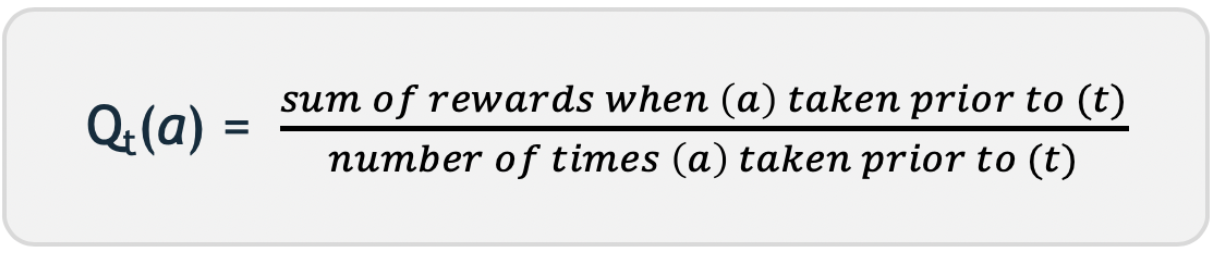

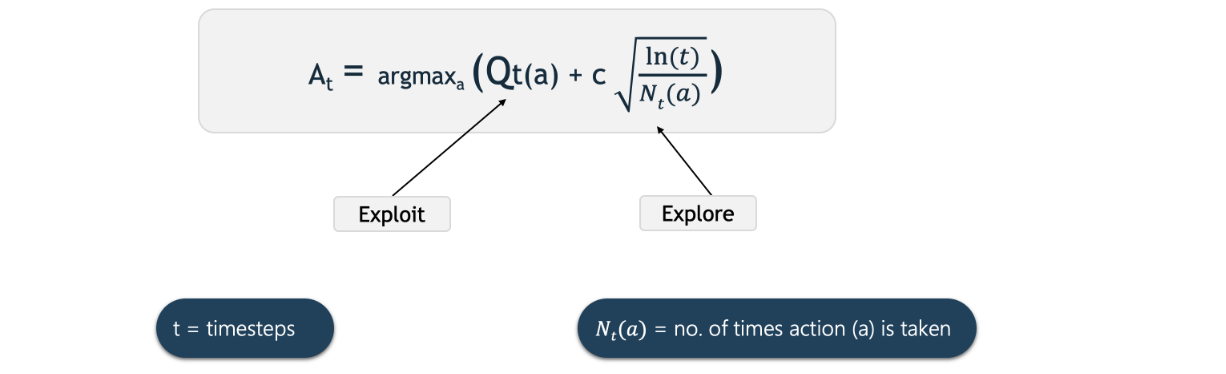

In [7]:
class UCB():
    def __init__(self, C):
        self.C = C
        self.t = 0
        self.eps = 1e-6
    def __call__(self, history: pd.DataFrame):
        self.t += 1
        exploitation = history['clicks'] / (history['impressions'] + self.eps) ## избежать деления на 0
        exploration = np.sqrt(np.log(self.t) / (history['impressions'] + self.eps))
        u = exploitation + self.C * exploration
        A_t = np.argmax(u)
        return history.index[A_t]

##### Посмотрим при дефолтном C = 1, как будет вести себя модель

In [8]:
seed = 18475
np.random.seed(seed=seed)
policy = UCB(1)
output = simulation(policy, n=n, seed=seed)
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(7046.796602204778, 0.03523398301102389, 184)

##### Достаточно высокий регрет, поищем теперь на сетке (лог.шкала -> линейная шкала)

In [9]:
C_log_grid = np.array([0.0001,0.001,0.01,0.1,1])

In [10]:
%%time
best_regret = output['regret'] ### Текущий на бейзлайне
best_C = 1

for cur_c in C_log_grid:
    seed = 18475
    np.random.seed(seed=seed)
    cur_policy = UCB(C = cur_c)
    cur_output = simulation(cur_policy, n=n, seed=seed,verbose=False)
    print(f'C: {cur_c}, current regret: {cur_output["regret"]}')
    if cur_output['regret']<best_regret:
        best_C = cur_c
        best_regret = cur_output['regret']

C: 0.0001, current regret: 4618.251491675675
C: 0.001, current regret: 4618.1542180818205
C: 0.01, current regret: 2473.9883190095406
C: 0.1, current regret: 168.1332874875451
C: 1.0, current regret: 7046.796602204778
CPU times: user 13min 27s, sys: 3.02 s, total: 13min 30s
Wall time: 13min 29s


##### Поищем в окрестности C оптимальные C*

In [11]:
lin_grid = np.linspace(best_C - 2*best_C*0.1, best_C+2*best_C*0.1,5)
print(lin_grid)

[0.08 0.09 0.1  0.11 0.12]


In [12]:
for cur_c in lin_grid:
    seed = 18475
    np.random.seed(seed=seed)
    cur_policy = UCB(C = cur_c)
    cur_output = simulation(cur_policy, n=n, seed=seed,verbose=False)
    print(f'C: {cur_c}, current regret: {cur_output["regret"]}')
    if cur_output['regret']<best_regret:
        best_C = cur_c

C: 0.08, current regret: 232.47311479450747
C: 0.09, current regret: 174.5901442389689
C: 0.1, current regret: 168.1332874875451
C: 0.11000000000000001, current regret: 239.0211872857353
C: 0.12000000000000001, current regret: 221.3488995000107


##### Получаем:

In [13]:
print(f'Best Regret: {best_regret}, best C: {best_C}')

Best Regret: 168.1332874875451, best C: 0.1


##### Итог: получилось улучшить регрет относительно бейзлайна + подобрали оптимальный C